In [916]:
# usamos libreria de Algebra Linear
using LinearAlgebra
using Logging
using Plots

In [917]:
@debug "Verbose debugging information.  Invisible by default"
@info  "An informational message"
@warn  "Something was odd.  You should pay attention"
@error "A non fatal error occurred"

┌ Info: An informational message
└ @ Main /home/mendez/github_repositories/my_repositories/quantum_optics/JaynesCummings_model.ipynb:2
┌ Warning: Something was odd.  You should pay attention
└ @ Main /home/mendez/github_repositories/my_repositories/quantum_optics/JaynesCummings_model.ipynb:3
┌ Error: A non fatal error occurred
└ @ Main /home/mendez/github_repositories/my_repositories/quantum_optics/JaynesCummings_model.ipynb:4


In [918]:
# Definimos frecuencias caracteristicas 
ω0 = Float64(100.0); println("ω0 = ",ω0);
g = Float64(abs(ω0/100.0)); println("g = ω0/100 = ",g);
m = 10; println("n = ",m);
println("ħ=1")

ω0 = 100.0
g = ω0/100 = 1.0
n = 10
ħ=1


In [919]:
# Definimos el hamiltoniano a diagonalizar
H = Matrix{Float64}(undef, 2, 2) # creamos matriz
H[:,:] = zeros(2,2)              # inicializamos matriz

α=ω0*(m+1);β=g*sqrt(m+1);

H[1,1] = α; H[1,2] = β;
H[2,1] = H[1,2] ; H[2,2] = H[1,1];

Expresamos $\hat{H}$ en la base $\mathcal{B}=\left\{ \ket{g,(n+1)},\ket{e,n} \right\}$ y mostramos su representación matricial en pantalla

In [920]:
println("H="); H

H=


2×2 Matrix{Float64}:
 1100.0         3.31662
    3.31662  1100.0

In [921]:
# calculamos las autoenergías del hamiltoniano (autovalores)
H_eigenvals = copy(eigvals(H))

2-element Vector{Float64}:
 1096.6833752096445
 1103.3166247903555

In [922]:
# calculamos los autoestados del hamiltonioano (autovectores)
H_eigenvectors = copy(eigvecs(H))

2×2 Matrix{Float64}:
 -0.707107  0.707107
  0.707107  0.707107

Hacemos el siguiente cambio de variable $\ket{g,(n+1)}\equiv\ket{\phi_0};\ket{e,n}\equiv\ket{\phi_1}$

In [923]:
# definimos el estado inicial (fundamental), estado auxiliar y estado excitado
ϕ0=[Float64(1),Float64(0)]; # vector columna (nivel fundamental del átomo y (n+1) fotones excitados)
ϕ1=[Float64(0),Float64(1)]; # vector columna (nivel excitado del átomo y (n) fotones excitadoso)

# creamos vector de tiempos
# tiempo inicial, tiempo final y numero de pasos
t_start=Float64(0);t_end=1.0;n=Int32(1000);
# calculamos paso temporal
Δt= abs(t_end-t_start)/Float64(n-1);
# creamos vector de tiempos
time_vector = [(t_start+Δt*Float64(i-1)) for i in 1:n];

In [924]:
# Calculamos cuál es la descomposición del estado inicial en la base de autoestados del hamiltoniano B:={|ϕj⟩}
# |ψ0⟩=∑aj|ϕj⟩ := estado inicial (vector columna)

function lineal_superposition(H_eigenvectors,ϕ)
    # vector columna de coeficientes de descomposición coeff_vector := [a1,a2,a3]
    coeff_vector = zero(Array{ComplexF64}(undef,length(H_eigenvectors[1,:])))
    coeff_vector = inv(H_eigenvectors)*ϕ
    return coeff_vector
end

lineal_superposition (generic function with 1 method)

In [925]:
# Realizamos la evolución temporal el hamiltoniano
# |ψ(t)⟩=∑exp[-i⋅ϵj⋅(t-t0)]|ψ0⟩

function evolution(ψ0::Array{Float64},H_eigenvals::Array{Float64},H_eigenvectors::Matrix{Float64},time_vector::Array{Float64})

    # vector columna de coeficientes de descomposición coeff_vector := [a1,a2,a3]
    coeff_vect = lineal_superposition(H_eigenvectors,ψ0)

    dim_time = length(time_vector)
    dim_eigvecs = length(H_eigenvectors[1,:])
    dim_eigvals = length(H_eigenvals)

    ψt = zeros(ComplexF64, dim_eigvecs, dim_time);

    for i in 1:dim_time
        for j in 1:dim_eigvecs
            for k in 1:dim_eigvals
                ψt[k,i]=exp(-im*H_eigenvals[k]*(time_vector[i]-time_vector[1]))*coeff_vect[k]*H_eigenvectors[j,k]
            end
        end
    end
    return ψt
end

evolution (generic function with 1 method)

In [926]:
ψ_t=evolution(ϕ0,H_eigenvals,H_eigenvectors,time_vector) # con estado inicial |ψ0⟩=|g⟩

2×1000 Matrix{ComplexF64}:
 -0.5+0.0im  -0.227786+0.445099im  …   0.482212-0.132179im
  0.5-0.0im   0.224826-0.446602im     -0.407634+0.289541im

In [927]:
# calculamos valores útiles
dim_time = length(time_vector)
dim_eigvecs = length(H_eigenvectors[1,:])

# definimos vector de probabilidades (población del estado excitado)
pϕ1=Array{ComplexF64}(undef, dim_time); # vector complejo
# vector de coeficientes aj tq |e⟩=∑aj|ϕj⟩, con |ϕj⟩ := base de autoestados de H
coeff_vect_ϕ1 = lineal_superposition(H_eigenvectors,ϕ1);

# definimos vector de probabilidades (población del estado fundamental)
pϕ0=Array{ComplexF64}(undef, dim_time);
# vector de coeficientes aj tq |g⟩=∑aj|ϕj⟩, con |ϕj⟩ := base de autoestados de H
coeff_vect_ϕ0 = lineal_superposition(H_eigenvectors,ϕ0);

for i in 1:dim_time
    ψ_t[:,i]=ψ_t[:,i]/norm(ψ_t[:,i]);     # normalizamos la vector de estado

    pϕ1[i]=adjoint(coeff_vect_ϕ1)*ψ_t[:,i]; # computamos ⟨e|ψt⟩=[∑(aj)*⟨ϕj|][∑bk|ϕk⟩]
    pϕ1[i]=abs(pϕ1[i])*abs(pϕ1[i])           # computamos |⟨e|ψt⟩|²

    pϕ0[i]=adjoint(coeff_vect_ϕ0)*ψ_t[:,i]; # computamos ⟨g|ψt⟩=[∑(aj)*⟨ϕj|][∑bk|ϕk⟩]
    pϕ0[i]=abs(pϕ0[i])*abs(pϕ0[i])           # computamos |⟨g|ψt⟩|²
end

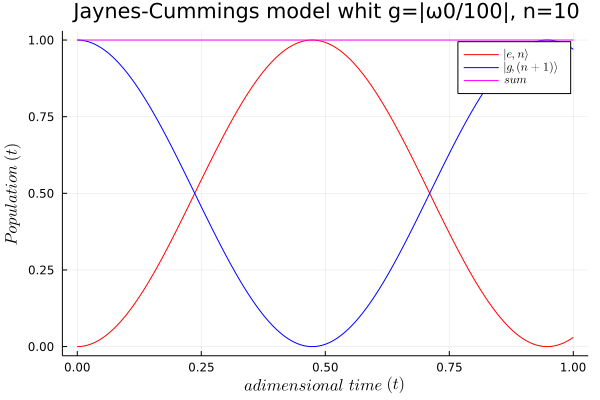

In [928]:
plt = plot()
plot!(plt, time_vector, real(pϕ1), color = :red, label = "\$|e,n⟩\$")
plot!(plt, time_vector, real(pϕ0), color = :blue, label = "\$|g,(n+1)⟩\$")
plot!(plt, time_vector, real(pϕ1)+real(pϕ0), color = :magenta, label = "\$sum\$")
plot!(ylabel = "\$Population\$ \$(t)\$", xlabel = "\$adimensional\$ \$time\$ \$(t)\$")
plot!(title = "Jaynes-Cummings model whit g=|ω0/100|, n=$(m)")
plot!(plt, legend = :topright)

In [929]:
function period_oscillator(time_vector,osc_function,ϵ)
    T=time_vector[1]
    counter=1;index=1;
    for i in 2:length(time_vector)
        if (abs(osc_function[i]-osc_function[1]) < ϵ)
            T=T+abs(time_vector[index]-time_vector[i]);counter=counter+1
            index=i
        end
    end
    ω=(2*π)/(T/Float64(counter))
    # retornamos tupla de frecuencia y período de oscilación
    return ω,T
end

period_oscillator (generic function with 2 methods)

In [930]:
info_pϕ1=period_oscillator(time_vector,real(pϕ1),1e-6);
println("Ω=",info_pϕ1[1],"\nT=",info_pϕ1[2]);

Ω=13.2704061773201
T=0.9469469469469469


Resolvemos la evolución para un estado coherente

In [931]:
# Definimos frecuencias caracteristicas 
ω0 = Float64(100.0); println("ω0 = ",ω0);
g = Float64(abs(ω0/100.0)); println("g = ω0/100 = ",g);
m = 10; println("n = ",m);
println("ħ=1")

ω0 = 100.0
g = ω0/100 = 1.0
n = 10
ħ=1


In [932]:
α=sqrt(10);
αcoeff1=((α^m)*exp(-0.5*(abs(α)^2)))/sqrt(factorial(m));
αcoeff2=((α^(m+1))*exp(-0.5*(abs(α)^2)))/sqrt(factorial(m+1));

In [933]:
# Definimos el hamiltoniano a diagonalizar
H1 = Matrix{Float64}(undef, 2, 2) # creamos matriz
H1[:,:] = zeros(2,2)              # inicializamos matri
α1=ω0*(m+1);β1=g*sqrt(m+1);
H1[1,1] = α1; H1[1,2] = β1;
H1[2,1] = H1[1,2] ; H1[2,2] = H1[1,1];

# Definimos el hamiltoniano a diagonalizar
H2 = Matrix{Float64}(undef, 2, 2) # creamos matriz
H2[:,:] = zeros(2,2)              # inicializamos matri
α2=ω0*(m+2);β2=g*sqrt(m+2);
H2[1,1] = α2; H2[1,2] = β2;
H2[2,1] = H2[1,2] ; H2[2,2] = H2[1,1];

# calculamos las autoenergías del hamiltoniano (autovalores)
H1_eigenvals = copy(eigvals(H1));H2_eigenvals = copy(eigvals(H2));
# calculamos los autoestados del hamiltonioano (autovectores)
H1_eigenvectors = copy(eigvecs(H1));H2_eigenvectors = copy(eigvecs(H2));

In [934]:
ψ1_t=evolution(αcoeff1*ϕ0,H1_eigenvals,H1_eigenvectors,time_vector) # con estado inicial |ψ0⟩=|g⟩
ψ2_t=evolution(αcoeff2*ϕ0,H2_eigenvals,H2_eigenvectors,time_vector) # con estado inicial |ψ0⟩=|g⟩

2×1000 Matrix{ComplexF64}:
 -0.168624+0.0im  -0.0614583+0.157025im  …   0.154588+0.0673547im
  0.168624-0.0im   0.0603678-0.157448im     -0.164024+0.0391178im

In [935]:
# calculamos valores útiles
dim_time = length(time_vector)
dim_eigvecs = length(H1_eigenvectors[1,:])

# definimos vector de probabilidades (población del estado excitado)
pϕ1_1=Array{ComplexF64}(undef, dim_time); # vector complejo
# vector de coeficientes aj tq |e⟩=∑aj|ϕj⟩, con |ϕj⟩ := base de autoestados de H
coeff_vect_ϕ1 = lineal_superposition(H1_eigenvectors,αcoeff1*ϕ1);

# definimos vector de probabilidades (población del estado fundamental)
pϕ0_1=Array{ComplexF64}(undef, dim_time);
# vector de coeficientes aj tq |g⟩=∑aj|ϕj⟩, con |ϕj⟩ := base de autoestados de H
coeff_vect_ϕ0 = lineal_superposition(H1_eigenvectors,αcoeff1*ϕ0);

for i in 1:dim_time
    ψ1_t[:,i]=ψ1_t[:,i]/norm(ψ1_t[:,i]);     # normalizamos la vector de estado

    pϕ1_1[i]=adjoint(coeff_vect_ϕ1)*ψ1_t[:,i]; # computamos ⟨e|ψt⟩=[∑(aj)*⟨ϕj|][∑bk|ϕk⟩]
    pϕ1_1[i]=abs(pϕ1_1[i])*abs(pϕ1_1[i])           # computamos |⟨e|ψt⟩|²

    pϕ0_1[i]=adjoint(coeff_vect_ϕ0)*ψ1_t[:,i]; # computamos ⟨g|ψt⟩=[∑(aj)*⟨ϕj|][∑bk|ϕk⟩]
    pϕ0_1[i]=abs(pϕ0_1[i])*abs(pϕ0_1[i])           # computamos |⟨g|ψt⟩|²
end

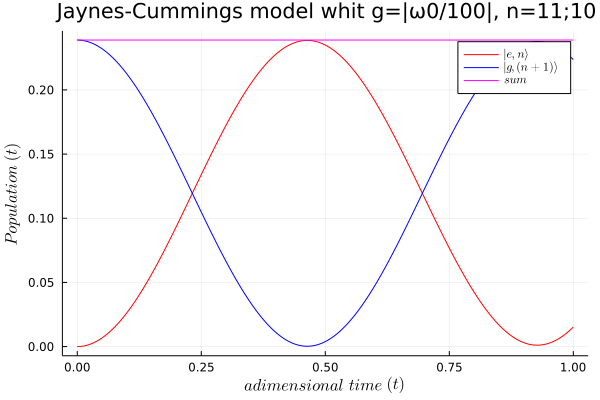

In [936]:
# calculamos valores útiles
dim_time = length(time_vector)
dim_eigvecs = length(H2_eigenvectors[1,:])

# definimos vector de probabilidades (población del estado excitado)
pϕ1_2=Array{ComplexF64}(undef, dim_time); # vector complejo
# vector de coeficientes aj tq |e⟩=∑aj|ϕj⟩, con |ϕj⟩ := base de autoestados de H
coeff_vect_ϕ1 = lineal_superposition(H2_eigenvectors,αcoeff2*ϕ1);

# definimos vector de probabilidades (población del estado fundamental)
pϕ0_2=Array{ComplexF64}(undef, dim_time);
# vector de coeficientes aj tq |g⟩=∑aj|ϕj⟩, con |ϕj⟩ := base de autoestados de H
coeff_vect_ϕ0 = lineal_superposition(H2_eigenvectors,αcoeff2*ϕ0);

for i in 1:dim_time
    ψ2_t[:,i]=ψ2_t[:,i]/norm(ψ2_t[:,i]);     # normalizamos la vector de estado

    pϕ1_2[i]=adjoint(coeff_vect_ϕ1)*ψ2_t[:,i]; # computamos ⟨e|ψt⟩=[∑(aj)*⟨ϕj|][∑bk|ϕk⟩]
    pϕ1_2[i]=abs(pϕ1_2[i])*abs(pϕ1_2[i])           # computamos |⟨e|ψt⟩|²

    pϕ0_2[i]=adjoint(coeff_vect_ϕ0)*ψ2_t[:,i]; # computamos ⟨g|ψt⟩=[∑(aj)*⟨ϕj|][∑bk|ϕk⟩]
    pϕ0_2[i]=abs(pϕ0_2[i])*abs(pϕ0_2[i])           # computamos |⟨g|ψt⟩|²
end

plt = plot()
plot!(plt, time_vector, real(pϕ1_1)+real(pϕ1_2), color = :red, label = "\$|e,n⟩\$")
plot!(plt, time_vector, real(pϕ0_1)+real(pϕ0_2), color = :blue, label = "\$|g,(n+1)⟩\$")
plot!(plt, time_vector, real(pϕ1_1)+real(pϕ0_1)+real(pϕ1_2)+real(pϕ0_2), color = :magenta, label = "\$sum\$")
plot!(ylabel = "\$Population\$ \$(t)\$", xlabel = "\$adimensional\$ \$time\$ \$(t)\$")
plot!(title = "Jaynes-Cummings model whit g=|ω0/100|, n=$(m+1);$(m)")
plot!(plt, legend = :topright)